In [1]:
# ## 자전거 대여 수요 예측 - Bike Sharing Demand

# - 데이터 전처리 및 가공 시각화
# - 로그 변환, 피처 인코딩과 모델 학습/예측/평가


# 이 데이터셋은 두 해에 걸친 시간별 자전거 대여 데이터를 제공합니다. 이 대회에서는 매월 1일부터 19일까지의 데이터가 훈련 세트로 구성되며, 테스트 세트는 20일부터 그 달의 끝까지입니다. 테스트 세트에 포함된 각 시간 동안의 자전거 총 대여 수를 예측해야 하며, 대여 기간 이전에만 사용할 수 있는 정보를 이용해야 합니다.

# 데이터 필드 설명:

# datetime: 시간별 날짜 및 타임스탬프
# season: 계절을 나타내며, 1은 봄, 2는 여름, 3은 가을, 4는 겨울입니다.
# holiday: 해당 날짜가 휴일로 간주되는지 여부
# workingday: 해당 날짜가 주말이나 휴일이 아닌 평일인지 여부
# weather: 날씨 상태로, 1은 맑음, 구름 조금, 대체로 흐림, 약간 흐림을 나타냅니다. 2는 안개 + 흐림, 안개 + 부서진 구름, 안개 + 조금 구름, 안개를 나타냅니다. 3은 가벼운 눈, 가벼운 비 + 뇌우 + 흩어진 구름, 가벼운 비 + 흩어진 구름을 나타냅니다. 4는 폭우 + 얼음판 + 뇌우 + 안개, 눈 + 안개를 나타냅니다.
# temp: 섭씨 온도
# atemp: "체감" 온도(섭씨)
# humidity: 상대 습도
# windspeed: 풍속
# casual: 비등록 사용자의 대여 건수
# registered: 등록 사용자의 대여 건수
# count: 총 대여 건수

# 이 데이터에서 holiday가 0이고 workingday가 1인 것은 해당 날짜가 휴일이 아니라는 것과, 주말이나 휴일이 아닌 평일이라는 것을 의미합니다.  이날은 일한다

holiday가 0이고 workingday도 0이면, 해당 날짜가 휴일도 아니고 평일도 아니라는 뜻입니다. 

그 날은 주말(토요일 또는 일요일)이라는 의미가 됩니다.

holiday = 0: 공휴일이 아님    workingday = 0: 평일(업무일)이 아님 따라서, 휴일도 아니고 평일도 아니면 주말일 가능성이 높습니다.    이날은 쉰다

# 2012년 10월 8일은 콜럼버스 데이라고 그 당시에 워싱턴dc 에서는 공휴일이었음 그래서 holiday 1 workingday 0 임   이날은 쉬었다 지금은 pc주의라서 공휴일에서 제외됨

#여하튼 홀리데이와 워킹데이 둘 중 하나만 1이면 일하러 가는 것


In [2]:
import pandas as pd

df = pd.read_csv('bike_train.csv')

print(df.head())
print(df.info())

              datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1  2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2  2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3  2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4  2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32  
3        75        0.0       3          10     13  
4        75        0.0       0           1      1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-n

1. 다중공선성 문제가 생길 수 있는 중복되는 열 제거 temp, atemp, casual, registered -> temp 열을 드랍, atemp열만 남김, casul, registered 열 드랍
2. datetime 월 일 시간 으로 나눠서 새로운 열 제작하고 datetime 은 드랍
3. 계절도 봄 여름 가을 겨울 로 새로운 열을 만들고 봄에 해당하면 1 나머지는 0 으로 원 핫딜 만들기, season 열을 드랍
4. 홀리데이 워킹데이 합치기 'holiday'가 0이고 'workingday'가 1인 경우 1로 설정, 그 외의 경우 0으로 설정 하는 '사람들일하러감' 이라는
새로운 열을 만들고 workingday 열과 holiday열은 드랍하기
5. 다중공선성 문제 되는지 확인해보기
6. 이상치 제거, 워싱턴 디씨 사람들은 왜 새벽에 자전거를 빌리는지 확인
7. 어느 계절에, 어느 시간대에 가장 많이 빌리는지 시각화
8. 어떤 기계학습 모델이 가장 적합한지 5폴드로 돌려 보기
9. 릿지 라쏘 엘라스틱 해보기
10. 하이퍼 파라미터 조종으로 최종 mae, rmae, 결정계수, rmsle 구하기


In [3]:
# 1. 다중공선성 문제가 생길 수 있는 중복되는 열 제거 temp, atemp, casual, registered -> temp 열을 드랍, atemp열만 남김, casul, registered 열 드랍
# 2. datetime 월 일 시간 으로 나눠서 새로운 열 제작하고 datetime 은 드랍
# 3. 계절도 봄 여름 가을 겨울 로 새로운 열을 만들고 봄에 해당하면 1 나머지는 0 으로 원 핫딜 만들기, season 열을 드랍
# 4. 홀리데이 워킹데이 합치기 'holiday'가 0이고 'workingday'가 1인 경우 1로 설정, 그 외의 경우 0으로 설정 하는 '사람들일하러감' 이라는
# 새로운 열을 만들고 workingday 열과 holiday열은 드랍하기

import pandas as pd

df = pd.read_csv('bike_train.csv')

# 1. 'temp', 'casual', 'registered' 열 제거
df.drop(['temp', 'casual', 'registered'], axis=1, inplace=True)

# 2. 'datetime' 열을 분리
df['datetime'] = pd.to_datetime(df['datetime'])
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df.drop('datetime', axis=1, inplace=True)

# 3. 계절(Season)을 봄, 여름, 가을, 겨울로 원-핫 인코딩
df['봄'] = (df['month'].apply(lambda x: x in [3, 4, 5])).astype(int)
df['여름'] = (df['month'].apply(lambda x: x in [6, 7, 8])).astype(int)
df['가을'] = (df['month'].apply(lambda x: x in [9, 10, 11])).astype(int)
df['겨울'] = (df['month'].apply(lambda x: x in [12, 1, 2])).astype(int)
df.drop(['season', 'month'], axis=1, inplace=True)

# 4. 'holiday'와 'workingday'를 결합하여 '사람들일하러감' 열 생성 및 원래 열 제거
df['사람들일하러감'] = ((df['holiday'] == 0) & (df['workingday'] == 1)).astype(int)
df.drop(['holiday', 'workingday'], axis=1, inplace=True)

# 5. 'count' 열을 맨 오른쪽으로 이동
count_column = df.pop('count')
df['count'] = count_column

# 결과 확인
df.head()


,weather,atemp,humidity,windspeed,day,hour,봄,여름,가을,겨울,사람들일하러감,count
0,1,14.395,81,0.0,1,0,0,0,0,1,0,16
1,1,13.635,80,0.0,1,1,0,0,0,1,0,40
2,1,13.635,80,0.0,1,2,0,0,0,1,0,32
3,1,14.395,75,0.0,1,3,0,0,0,1,0,13
4,1,14.395,75,0.0,1,4,0,0,0,1,0,1


In [4]:
# 5. 다중공선성 문제가 있는지 확인해보기

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pandas as pd

# 상수항 추가하고 count 열 제외 (VIF 계산을 위해 필요)
df_vif = add_constant(df.drop('count', axis=1))

# VIF 계산
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]
vif["features"] = df_vif.columns

# VIF 결과 출력
print(vif)



    VIF Factor   features
0     0.000000      const
1     1.253883    weather
2     2.603072      atemp
3     1.503877   humidity
4     1.163172  windspeed
5     1.001876        day
6     1.153541       hour
7          inf          봄
8          inf         여름
9          inf         가을
10         inf         겨울
11    1.003764    사람들일하러감


c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [5]:
#inf 는 무한대라서 다중공선성 문제가 생기고 있음, 봄 열을 제거 하고 다시 계산

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# '봄' 열을 제거
df_vif = df.drop(['봄', 'count'], axis=1)  # 'count' 열과 '봄' 열 제외
df_vif = add_constant(df_vif)  # 상수항 추가

# 수정된 데이터셋에 대한 VIF 계산
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]
vif["features"] = df_vif.columns

vif

#vif 값이 상수항을 제외하고 5 이하이므로 다중공선성 문제는 없어 보임



,VIF Factor,features
0,50.500423,const
1,1.253883,weather
2,2.603072,atemp
3,1.503877,humidity
4,1.163172,windspeed
5,1.001876,day
6,1.153541,hour
7,2.254510,여름
8,1.556513,가을
9,1.949307,겨울


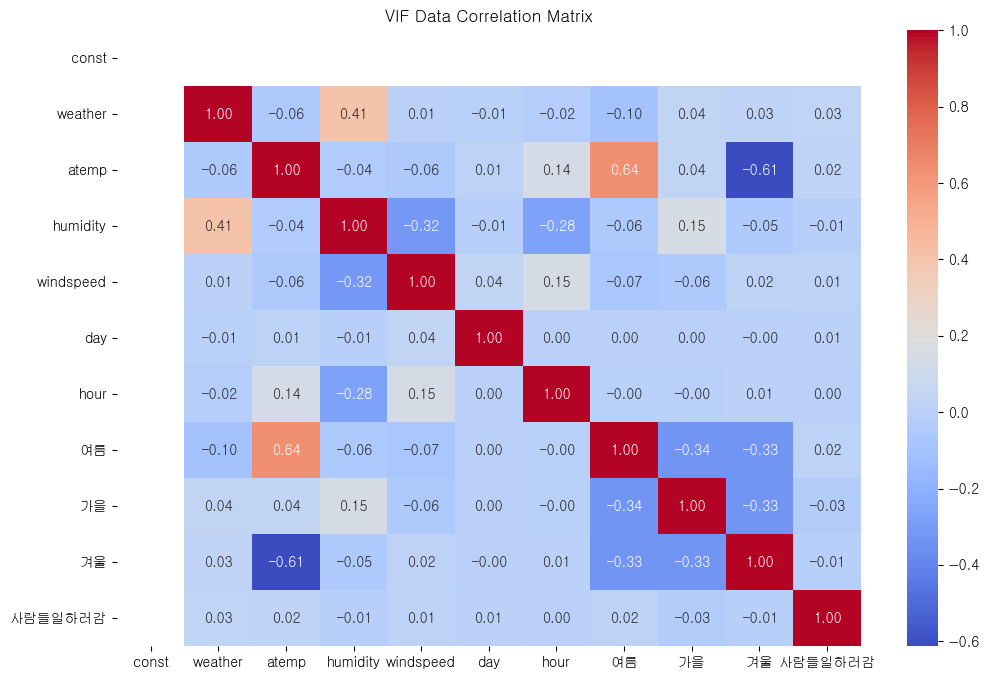

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Gulim'

# 상관관계 행렬 계산
correlation_matrix = df_vif.corr()

# 히트맵 그리기
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("VIF Data Correlation Matrix")
plt.show()

#피어슨 상관계수도 0.7 이하이므로 다중공선성 없어 보임

워싱턴 디씨는 미국 수도 답게 관광객도 많고 자전거 도로가 잘되어 있어서 새벽에도 많이 타고 다닌다고 함 

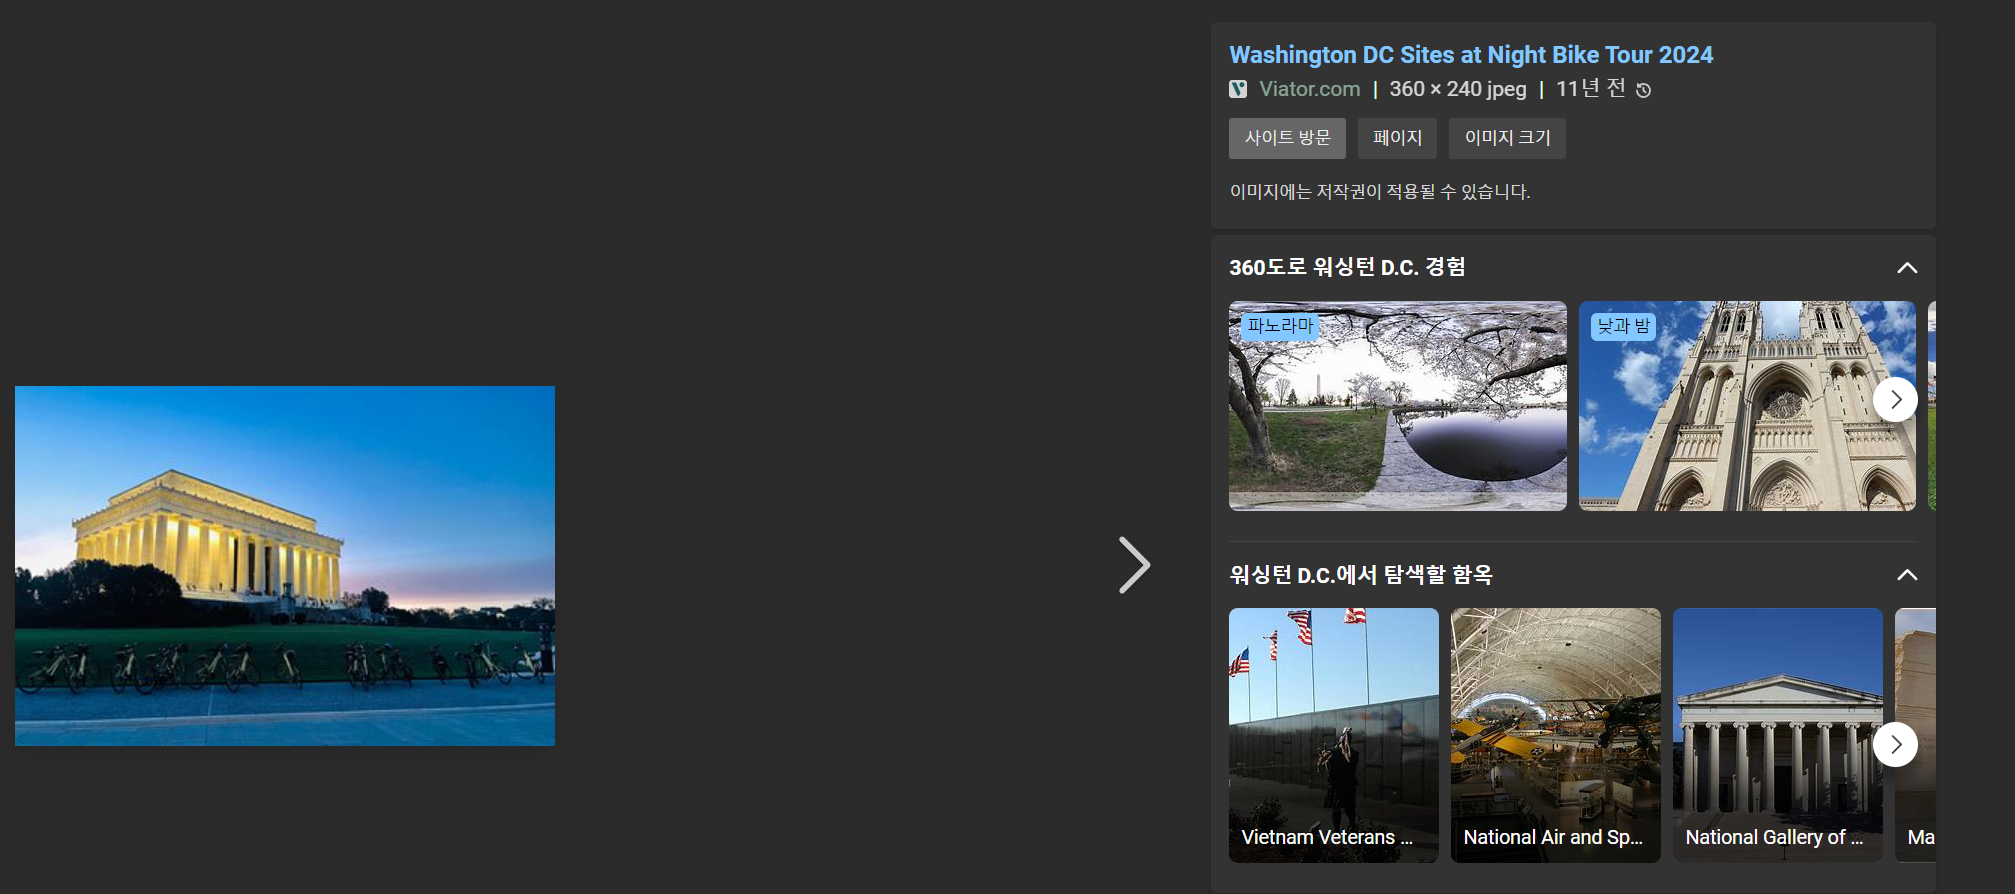

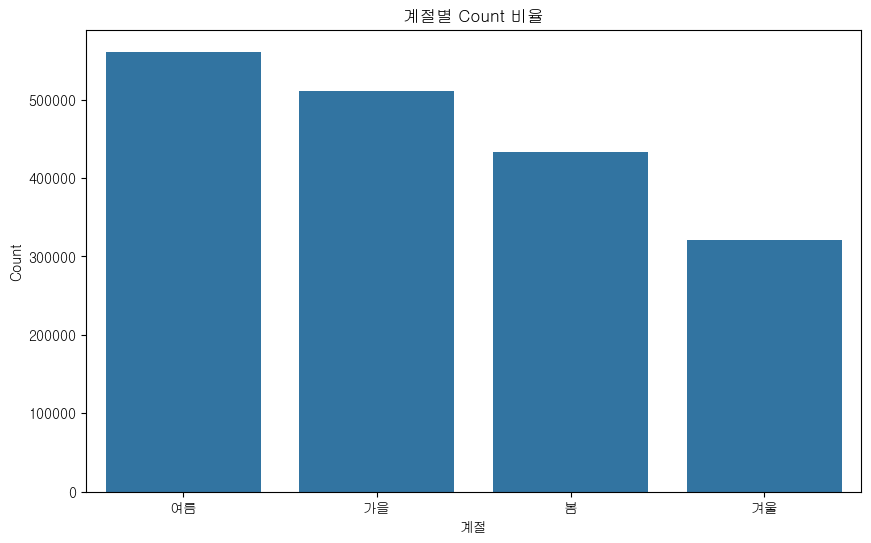

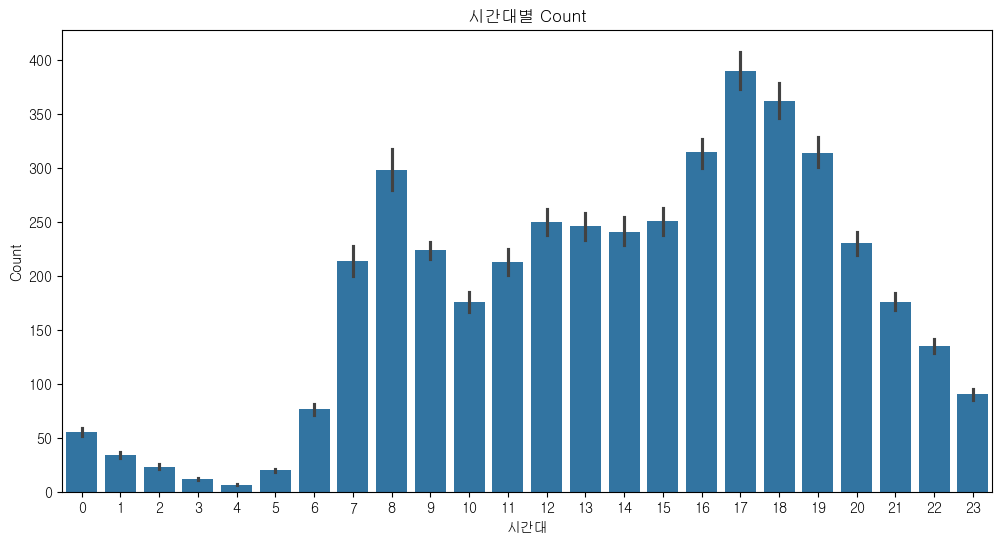

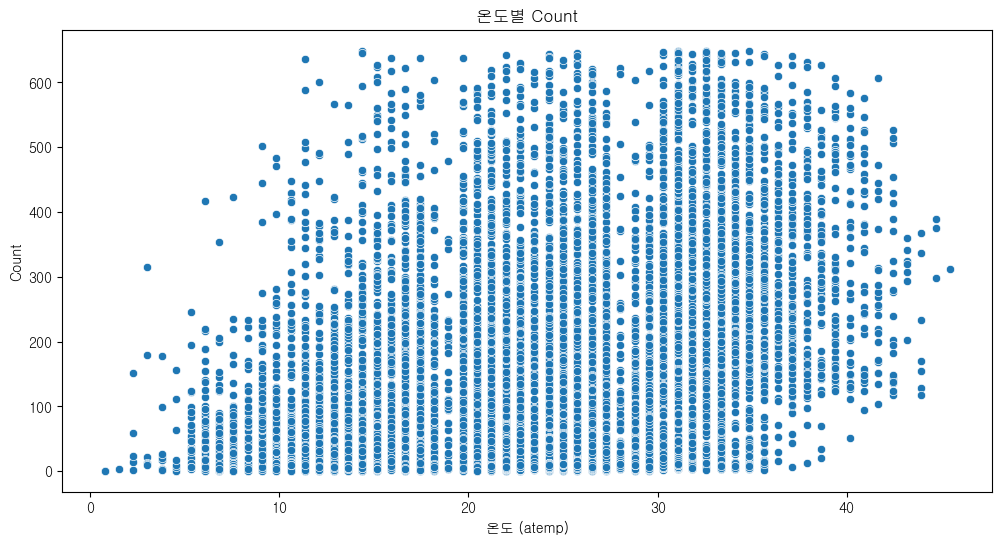

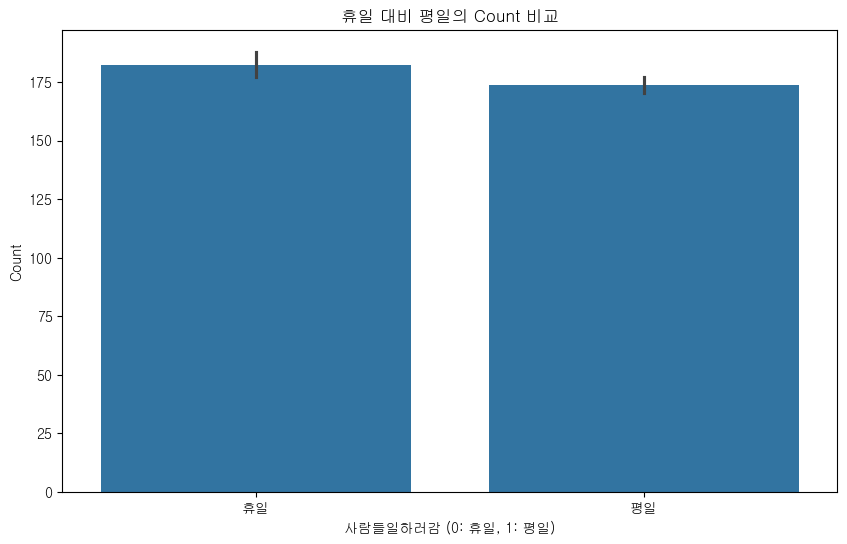

In [7]:
# 6. 이상치 제거, 워싱턴 디씨 사람들은 왜 새벽에 자전거를 빌리는지 확인
# 7. 어느 계절에, 어느 시간대에 가장 많이 빌리는지 시각화

import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Gulim'

# 이상치를 제거한 데이터셋을 df1로 저장
df1 = df.copy()

# 이상치를 제거할 열 선택
columns_to_check = ['atemp', 'humidity', 'windspeed', 'count']

# IQR을 기반으로 이상치 제거
for col in columns_to_check:
    Q1 = df1[col].quantile(0.25)
    Q3 = df1[col].quantile(0.75)
    IQR = Q3 - Q1
    df1 = df1[~((df1[col] < (Q1 - 1.5 * IQR)) | (df1[col] > (Q3 + 1.5 * IQR)))]

# 계절별 count 비율 시각화
seasons = ['봄', '여름', '가을', '겨울']
season_counts = df1[seasons].multiply(df1['count'], axis="index").sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=season_counts.index, y=season_counts.values)
plt.title('계절별 Count 비율')
plt.ylabel('Count')
plt.xlabel('계절')
plt.show()

# 시간대별 count 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x='hour', y='count', data=df1)
plt.title('시간대별 Count')
plt.ylabel('Count')
plt.xlabel('시간대')
plt.show()

# 온도별 count 시각화
plt.figure(figsize=(12, 6))
sns.scatterplot(x='atemp', y='count', data=df1)
plt.title('온도별 Count')
plt.ylabel('Count')
plt.xlabel('온도 (atemp)')
plt.show()

# '사람들일하러감' 컬럼을 이용한 휴일과 평일 일 때의 count 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='사람들일하러감', y='count', data=df1)
plt.title('휴일 대비 평일의 Count 비교')
plt.ylabel('Count')
plt.xlabel('사람들일하러감 (0: 휴일, 1: 평일)')
plt.xticks([0, 1], ['휴일', '평일'])
plt.show()

In [ ]:
# 원핫 인코딩 쉽게 하는 방법은

# X_features_ohe = pd.get_dummies(X_feautres, columns=['year', 'month', 'day', 'hour', 'holiday', 'workingday', 'season', 'weather'])


In [8]:
print(df1.info())
print()
print(df1.head())

#이상치 제거하고 500개 행 정도 삭제됨

<class 'pandas.core.frame.DataFrame'>
Index: 10352 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   weather    10352 non-null  int64  
 1   atemp      10352 non-null  float64
 2   humidity   10352 non-null  int64  
 3   windspeed  10352 non-null  float64
 4   day        10352 non-null  int32  
 5   hour       10352 non-null  int32  
 6   봄          10352 non-null  int32  
 7   여름         10352 non-null  int32  
 8   가을         10352 non-null  int32  
 9   겨울         10352 non-null  int32  
 10  사람들일하러감    10352 non-null  int32  
 11  count      10352 non-null  int64  
dtypes: float64(2), int32(7), int64(3)
memory usage: 768.3 KB
None

   weather   atemp  humidity  windspeed  day  hour  봄  여름  가을  겨울  사람들일하러감  \
0        1  14.395        81        0.0    1     0  0   0   0   1        0   
1        1  13.635        80        0.0    1     1  0   0   0   1        0   
2        1  13.635        80      

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
import numpy as np

# 독립 변수와 종속 변수 설정
X = df1.drop('count', axis=1)
y = df1['count']


# X와 y를 학습용과 테스트용으로 8:2 비율로 분할
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 모델 정의
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor()
}

# 모델별로 교차검증 및 평가지표 계산
for name, model in models.items():
    # 5-fold cross validation
    cv_scores = cross_val_score(model, X, y, cv=5)
    # 모델 학습
    model.fit(X_train, y_train)
    # 예측값 생성
    y_pred = model.predict(X_test)
    # count 예측값이 음수인 경우 0으로 대체
    y_pred = np.clip(y_pred, 0, None)
    # 평가지표 계산
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    rmsle = mean_squared_log_error(y_test, y_pred, squared=False)
    # 결과 출력
    print(f"{name} 모델의 결과입니다.")
    print(f"교차검증 점수: {cv_scores.mean():.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"RMSLE: {rmsle:.4f}")
    print()

#그나마 random forest 가 rmsle 0.4519 로 제일 나음   random forest로 계속 진행



Linear Regression 모델의 결과입니다.
교차검증 점수: 0.1353
MAE: 94.5294
RMSE: 126.3491
RMSLE: 1.2339

Random Forest 모델의 결과입니다.
교차검증 점수: 0.4743
MAE: 41.5431
RMSE: 61.7680
RMSLE: 0.4509

Gradient Boosting 모델의 결과입니다.
교차검증 점수: 0.4969
MAE: 54.8193
RMSE: 76.9851
RMSLE: 0.7724



In [10]:
# 라쏘, 릿지, 엘라스틱 한번씩 해보기

from sklearn.linear_model import Lasso

# alpha 값의 범위 설정
alphas = [0, 0.1, 1, 10, 100]

# 각 alpha 값에 대해 Lasso 모델을 실행하는 for 구문
for alpha in alphas:
    # Lasso 모델 정의
    lasso = Lasso(alpha=alpha)   #alpha 값을 설정하지 않으면 디폴트 값은 1

    # Lasso 모델 학습
    lasso.fit(X_train, y_train)

    # Lasso 모델로 예측값 생성
    y_pred_lasso = lasso.predict(X_test)

    # 예측값이 음수인 경우 0으로 대체
    y_pred_lasso = np.clip(y_pred_lasso, 0, None)

    # Lasso 모델의 평가지표 계산
    mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
    rmse_lasso = mean_squared_error(y_test, y_pred_lasso, squared=False)
    rmsle_lasso = mean_squared_log_error(y_test, y_pred_lasso, squared=False)

    # Lasso 모델의 결과 출력
    print(f"alpha 값이 {alpha}일 때 Lasso 모델의 결과입니다.")
    print(f"MAE: {mae_lasso:.4f}")
    print(f"RMSE: {rmse_lasso:.4f}")
    print(f"RMSLE: {rmsle_lasso:.4f}")
    print()



#라쏘는 여기에 맞지 않나 보다 라쏘는 쓰지 않기로


alpha 값이 0일 때 Lasso 모델의 결과입니다.
MAE: 94.5294
RMSE: 126.3491
RMSLE: 1.2339

alpha 값이 0.1일 때 Lasso 모델의 결과입니다.
MAE: 94.5577
RMSE: 126.3404
RMSLE: 1.2339

alpha 값이 1일 때 Lasso 모델의 결과입니다.
MAE: 94.8587
RMSE: 126.3302
RMSLE: 1.2314

alpha 값이 10일 때 Lasso 모델의 결과입니다.
MAE: 96.1184
RMSE: 127.4793
RMSLE: 1.2031

alpha 값이 100일 때 Lasso 모델의 결과입니다.
MAE: 98.2220
RMSE: 128.1774
RMSLE: 1.2505



c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.497e+07, tolerance: 2.049e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted us

In [11]:
from sklearn.linear_model import Ridge

# alpha 값의 범위 설정
alphas = [0, 0.1, 1, 10, 100]

# 각 alpha 값에 대해 Ridge 모델을 실행하는 for 구문
for alpha in alphas:
    # Ridge 모델 정의
    ridge = Ridge(alpha=alpha)   #alpha 값을 설정하지 않으면 디폴트 값은 1

    # Ridge 모델 학습
    ridge.fit(X_train, y_train)

    # Ridge 모델로 예측값 생성
    y_pred_ridge = ridge.predict(X_test)

    # 예측값이 음수인 경우 0으로 대체
    y_pred_ridge = np.clip(y_pred_ridge, 0, None)

    # Ridge 모델의 평가지표 계산
    mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
    rmse_ridge = mean_squared_error(y_test, y_pred_ridge, squared=False)
    rmsle_ridge = mean_squared_log_error(y_test, y_pred_ridge, squared=False)

    # Ridge 모델의 결과 출력
    print(f"alpha 값이 {alpha}일 때 Ridge 모델의 결과입니다.")
    print(f"MAE: {mae_ridge:.4f}")
    print(f"RMSE: {rmse_ridge:.4f}")
    print(f"RMSLE: {rmsle_ridge:.4f}")
    print()


#릿지도 성능이 좋지 않음


alpha 값이 0일 때 Ridge 모델의 결과입니다.
MAE: 94.5054
RMSE: 126.3132
RMSLE: 1.2274

alpha 값이 0.1일 때 Ridge 모델의 결과입니다.
MAE: 94.5294
RMSE: 126.3490
RMSLE: 1.2339

alpha 값이 1일 때 Ridge 모델의 결과입니다.
MAE: 94.5300
RMSE: 126.3487
RMSLE: 1.2338

alpha 값이 10일 때 Ridge 모델의 결과입니다.
MAE: 94.5353
RMSE: 126.3457
RMSLE: 1.2338

alpha 값이 100일 때 Ridge 모델의 결과입니다.
MAE: 94.5870
RMSE: 126.3256
RMSLE: 1.2326



In [12]:
from sklearn.linear_model import ElasticNet

# 엘라스틱 넷 모델 정의
elastic = ElasticNet()

# 엘라스틱 넷 모델 학습
elastic.fit(X_train, y_train)

# 엘라스틱 넷 모델로 예측값 생성
y_pred_elastic = elastic.predict(X_test)

# 예측값이 음수인 경우 0으로 대체
y_pred_elastic = np.clip(y_pred_elastic, 0, None)

# 엘라스틱 넷 모델의 평가지표 계산
mae_elastic = mean_absolute_error(y_test, y_pred_elastic)
rmse_elastic = mean_squared_error(y_test, y_pred_elastic, squared=False)
rmsle_elastic = mean_squared_log_error(y_test, y_pred_elastic, squared=False)

# 엘라스틱 넷 모델의 결과 출력
print("엘라스틱 넷 모델의 결과입니다.")
print(f"MAE: {mae_elastic:.4f}")
print(f"RMSE: {rmse_elastic:.4f}")
print(f"RMSLE: {rmsle_elastic:.4f}")
print()


엘라스틱 넷 모델의 결과입니다.
MAE: 95.5167
RMSE: 126.8938
RMSLE: 1.2154



In [13]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_log_error, make_scorer
# import numpy as np

# # 데이터 준비
# X = df1.drop('count', axis=1)
# y = df1['count']

# # 랜덤 포레스트 모델 정의
# rfr = RandomForestRegressor(random_state=42)

# # 하이퍼파라미터 그리드 설정
# param_grid = {
#     'n_estimators': [10, 50, 100, 200, 500],
#     'max_depth': [None, 5, 10, 20, 50],
#     'max_features': ["sqrt", "log2", 0.5, 0.8, None],
#     'min_samples_split': [2, 5, 10, 20, 50],
#     'min_samples_leaf': [1, 2, 5, 10, 20]
# }

# # RMSLE 스코어 함수 정의 (낮을수록 좋음)
# def rmsle(y_true, y_pred):
#     return np.sqrt(mean_squared_log_error(y_true, y_pred))

# rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

# # GridSearchCV 설정
# grid_search = GridSearchCV(estimator=rfr, param_grid=param_grid, scoring=rmsle_scorer, cv=3, n_jobs=-1, verbose=2)

# # 모델 학습
# grid_search.fit(X_train, y_train)

# # 최적의 파라미터와 RMSLE 값 출력
# print("Best parameters found: ", grid_search.best_params_)
# print("Best RMSLE: ", -grid_search.best_score_)


In [19]:
# #10. 랜덤 포레스트로 하이퍼 파라미터 조종으로 최종 mae, rmae, 결정계수, rmsle 구하기

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error
import numpy as np

# 데이터 준비
X = df1.drop('count', axis=1)
y = df1['count']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 랜덤 포레스트 모델 정의
rfr = RandomForestRegressor(random_state=42)

#최적의 하이퍼 파라미터 찾기 (그냥 기본값으로 하는게 제일 최적인 상태)
#rfr.set_params(n_estimators=100, max_depth=10, ...)

# 모델 학습
rfr.fit(X_train, y_train)

# 예측
y_pred = rfr.predict(X_test)

# 평가 지표 계산
mae = mean_absolute_error(y_test, y_pred)
rmae = np.sqrt(mae)  # Root Mean Absolute Error
r2 = r2_score(y_test, y_pred)  # 결정계수
rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))  # Root Mean Squared Log Error

# 결과 출력
print(f"MAE: {mae}")
print(f"RMAE: {rmae}")
print(f"결정계수 (R^2): {r2}")
print(f"RMSLE: {rmsle}")


MAE: 41.30343505552873
RMAE: 6.426774856452397
결정계수 (R^2): 0.8437817545800851
RMSLE: 0.4501348246369953


In [16]:
def get_top_error_data(y_test, y_pred, n_tops=5):
    # 실제값과 예측값을 비교할 데이터프레임 생성
    result_df = pd.DataFrame()
    result_df['real_count'] = y_test
    result_df['predicted_count'] = np.round(y_pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])

    # 차이가 가장 큰 상위 n_tops개의 데이터 출력
    return result_df.sort_values('diff', ascending=False).head(n_tops)

# 함수 호출하여 결과 확인
top_errors = get_top_error_data(y_test, y_pred, n_tops=5)
print(top_errors)


       real_count  predicted_count   diff
10568         565            210.0  355.0
7786          645            372.0  273.0
36             75            339.0  264.0
8479          566            303.0  263.0
10318         646            386.0  260.0


In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# X와 y의 로그 변환
X_log = np.log1p(X)
y_log = np.log1p(y)

# 데이터 분할
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log, y_log, test_size=0.2, random_state=42)

# 랜덤 포레스트 모델 학습
rfr.fit(X_train_log, y_train_log)

# 예측 (로그 스케일)
y_pred_log = rfr.predict(X_test_log)

# 예측 결과를 원래 스케일로 변환
y_test_exp = np.expm1(y_test_log)
y_pred_exp = np.expm1(y_pred_log)

# MAE, RMAE, RLMSE 계산
mae = mean_absolute_error(y_test_exp, y_pred_exp)
rmae = np.sqrt(mae)
rmsle = np.sqrt(mean_squared_log_error(y_test_exp, y_pred_exp))

# 결과 출력
print(f"MAE: {mae}")
print(f"RMAE: {rmae}")
print(f"RMSLE: {rmsle}")


MAE: 40.664020346682996
RMAE: 6.376834665151904
RMSLE: 0.41957837018638156


In [18]:
def get_top_error_data_log_scale(y_test_exp, y_pred_exp, n_tops=5):
    # 실제값과 예측값을 비교할 데이터프레임 생성
    result_df = pd.DataFrame()
    result_df['real_count'] = y_test_exp
    result_df['predicted_count'] = np.round(y_pred_exp)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])

    # 차이가 가장 큰 상위 n_tops개의 데이터 출력
    return result_df.sort_values('diff', ascending=False).head(n_tops)

# 함수 호출하여 결과 확인
top_errors_log_scale = get_top_error_data_log_scale(y_test_exp, y_pred_exp, n_tops=5)
print(top_errors_log_scale)


       real_count  predicted_count   diff
8479        566.0            201.0  365.0
10654       584.0            237.0  347.0
10568       565.0            222.0  343.0
6362        549.0            251.0  298.0
7786        645.0            348.0  297.0


In [20]:
# 랜덤 포레스트 모델 학습 후 어떤 특성이 중요한지 알아보기
rfr.fit(X_train, y_train)

# 특성 중요도 추출
feature_importances = rfr.feature_importances_

# 특성 이름과 중요도를 매핑하고 정렬
importances = sorted(zip(X.columns, feature_importances), key=lambda x: x[1], reverse=True)

# 중요한 특성들 출력
for feature, importance in importances:
    print(f"{feature}: {importance}")


hour: 0.6116931455025856
atemp: 0.14929189936573495
humidity: 0.06713479612345531
사람들일하러감: 0.04867941302306527
day: 0.04033672850823237
windspeed: 0.03413452271586445
weather: 0.021958766829254066
가을: 0.011217673061535236
봄: 0.007080472462952076
여름: 0.0044772408701468785
겨울: 0.003995341537173881


In [ ]:
# mae 25까지 한거

import pandas as pd

# Load the CSV file
file_path = 'bike_train.csv'
df = pd.read_csv(file_path)

# Displaying the first few rows of the dataframe
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
import numpy as np

# Preprocessing
# Convert 'datetime' to datetime object and extract relevant features
df['datetime'] = pd.to_datetime(df['datetime'])
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['weekday'] = df['datetime'].dt.weekday

# Drop the original 'datetime' column and other irrelevant columns
df = df.drop(['datetime', 'casual', 'registered'], axis=1)

# Check for missing values
missing_values = df.isnull().sum()

# Data and target variable
X = df.drop('count', axis=1)
y = df['count']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Regressor
rfr = RandomForestRegressor(random_state=42)

# Hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rfr, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

# Predictions
y_pred = best_model.predict(X_test)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)

missing_values, mae, grid_search.best_params_


Fitting 3 folds for each of 81 candidates, totalling 243 fits


(season        0
 holiday       0
 workingday    0
 weather       0
 temp          0
 atemp         0
 humidity      0
 windspeed     0
 count         0
 year          0
 month         0
 day           0
 hour          0
 weekday       0
 dtype: int64,
 24.295479704875987,
 {'max_depth': 20,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 200})

In [ ]:
# Simplified hyperparameter grid
simple_param_grid = {
    'n_estimators': [200],  # Reduced number of estimators
    'max_depth': [20, None],  # Simplified depth options
    'min_samples_split': [2],  # Increased to reduce complexity
    'min_samples_leaf': [1]  # Increased to reduce complexity
}

# Perform GridSearch with a simpler parameter grid
simple_grid_search = GridSearchCV(estimator=rfr, param_grid=simple_param_grid, scoring='neg_mean_absolute_error', cv=3, n_jobs=-1, verbose=2)
simple_grid_search.fit(X_train, y_train)

# Best model from simplified grid search
best_simple_model = simple_grid_search.best_estimator_

# Predictions with the best model
y_pred_simple = best_simple_model.predict(X_test)

# Calculate MAE with the simplified model
mae_simple = mean_absolute_error(y_test, y_pred_simple)

mae_simple, simple_grid_search.best_params_


Fitting 3 folds for each of 2 candidates, totalling 6 fits


(24.295479704875987,
 {'max_depth': 20,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 200})

In [ ]:
from sklearn.metrics import mean_squared_log_error

# 주어진 하이퍼파라미터 값을 사용하여 랜덤 포레스트 모델 재정의
optimized_rfr = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42
)

# 모델 학습
optimized_rfr.fit(X_train, y_train)

# 예측
optimized_y_pred = optimized_rfr.predict(X_test)

# 평가 지표 계산
optimized_mae = mean_absolute_error(y_test, optimized_y_pred)
optimized_rmae = np.sqrt(optimized_mae)
optimized_rmsle = np.sqrt(mean_squared_log_error(y_test, optimized_y_pred))

# 결과 출력
print(f"MAE: {optimized_mae}")
print(f"RMAE: {optimized_rmae}")
print(f"RMSLE: {optimized_rmsle}")


MAE: 25.6698214923143
RMAE: 5.066539400055456
RMSLE: 0.3375813548401264


In [22]:
# #10. 랜덤 포레스트로 하이퍼 파라미터 조종으로 최종 mse, rmse, 결정계수, rmsle 구하기
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error


# X = df1.drop('count', axis=1)
# y = df1['count']

# # 랜덤 포레스트 모델 정의
# rfr = RandomForestRegressor(random_state=42)

# # 하이퍼 파라미터의 값들을 리스트로 만듦
# n_estimators = [10, 50, 100, 200, 500]
# max_depth = [None, 5, 10, 20, 50]
# max_features = ["sqrt", "log2", 0.5, 0.8, None] # 'auto' 대신 'sqrt'를 추가함
# min_samples_split = [2, 5, 10, 20, 50]
# min_samples_leaf = [1, 2, 5, 10, 20]

# # rmsle 값을 저장할 빈 리스트를 만듦
# rmsle_list = []

# # 각 하이퍼 파라미터의 조합에 대해 for 구문을 사용
# for n in n_estimators:
#     for d in max_depth:
#         for f in max_features:
#             for s in min_samples_split:
#                 for l in min_samples_leaf:
#                     # 랜덤 포레스트 모델에 하이퍼 파라미터를 설정
#                     rfr.set_params(n_estimators=n, max_depth=d, max_features=f, min_samples_split=s, min_samples_leaf=l)
#                     # 랜덤 포레스트 모델 학습
#                     rfr.fit(X_train, y_train)
#                     # 랜덤 포레스트 모델로 예측값 생성
#                     y_pred_rfr = rfr.predict(X_test)
#                     # 예측값이 음수인 경우 0으로 대체
#                     y_pred_rfr = np.clip(y_pred_rfr, 0, None)
#                     # 랜덤 포레스트 모델의 평가지표 계산
#                     mae_rfr = mean_absolute_error(y_test, y_pred_rfr)
#                     rmse_rfr = mean_squared_error(y_test, y_pred_rfr, squared=False)
#                     rmsle_rfr = mean_squared_log_error(y_test, y_pred_rfr, squared=False)
#                     # rmsle 값을 리스트에 추가
#                     rmsle_list.append(rmsle_rfr)
#                     # 랜덤 포레스트 모델의 결과 출력
#                     print(f"n_estimators={n}, max_depth={d}, max_features={f}, min_samples_split={s}, min_samples_leaf={l} 일 때 랜덤 포레스트 모델의 결과입니다.")
#                     print(f"MAE: {mae_rfr:.4f}")
#                     print(f"RMSE: {rmse_rfr:.4f}")
#                     print(f"RMSLE: {rmsle_rfr:.4f}")
#                     print()

# # rmsle_list에서 최소값을 찾음
# min_rmsle = min(rmsle_list)

# # 최소값과 일치하는 rmsle 값을 가진 하이퍼 파라미터의 조합을 출력
# print(f"best rmsle: {min_rmsle:.4f}")
